In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import time, copy 

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split


from quantum_circuit_simulator import quantum_circuit

from memory_profiler import memory_usage
from torch.profiler import profile, ProfilerActivity

In [2]:
cnn_metrics = {}
qnn_metrics = {}

In [3]:
# Load the dataset and transform it into tensors and normalized between -1 and 1.


transform = transforms.Compose([       
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)) 
])


def load_dataset(name):
    print(name,'\n')
    if name == "FashionMNIST":
        train_dataset = datasets.FashionMNIST(root="FashionMNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root="FashionMNIST", train=False, download=True, transform=transform)
    elif name == "MNIST":
        train_dataset = datasets.MNIST(root="MNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root="MNIST", train=False, download=True, transform=transform)
    return train_dataset, test_dataset 


# Choose either "MNIST" or "FashionMNIST" 
train_dataset_cnn, test_dataset_cnn = load_dataset("MNIST")

''' taking a fraction of the data for faster training and test '''

frac = 0.1
train_dataset_qnn, _ = random_split(train_dataset_cnn, [frac, 1-frac])
test_dataset_qnn, _ = random_split(test_dataset_cnn, [frac, 1-frac])

print(f'number of (train, test) examples for the CNN= {len(train_dataset_cnn), len(test_dataset_cnn)}')
print(f'number of (train, test) examples for the QNN= {len(train_dataset_qnn), len(test_dataset_qnn)}')

device = "cuda" if torch.cuda.is_available() else "cpu"    # Get gpu or cpu device for training
print(f"Using {device} device\n")

#=====================================================================================

MNIST 

number of (train, test) examples for the CNN= (60000, 10000)
number of (train, test) examples for the QNN= (6000, 1000)
Using cpu device



# Helper Functions

In [4]:

def performance_estimate(dataset, model, loss_fn, train_or_test, batch_size):
    '''this function computes accuracy and loss of a model on the training or test set'''
    data_size = len(dataset)
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(dataloader)
    
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            accuracy += (pred.argmax(1) == y).sum().item()
            loss += loss_fn(pred, y).item()
    accuracy /= data_size                                            # accuracy lies in the interval [0, 1]  
    loss /= num_batches
    print(f"{train_or_test} accuracy: {round(accuracy, 3)},  {train_or_test} loss: {round(loss,3)}")
    return accuracy, loss




def one_epoch(model, loss_fn, optimizer, dataset, batch_size, train_dataset, test_dataset):
    
    A_train, L_train, A_test, L_test = [], [], [], []

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        out = model(X)                             # Perform a single forward pass 
        loss = loss_fn(out, y)          
    
        optimizer.zero_grad()                      # Clear gradients
        loss.backward()                            # Derive gradients, backpropagation
        optimizer.step()                           # Update parameters based on gradients
        
    
        if batch % batch_size == 0: 
            #As training progress, computing and appending loss and accuracy of the model on train and test set
            accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train', batch_size)
            accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ', batch_size)
            print()
            
            A_train.append(accuracy_train)        
            L_train.append(loss_train)
            A_test.append(accuracy_test)
            L_test.append(loss_test)
            
            #print(f"train loss: {round(loss,3)}")
    
    return A_train, L_train, A_test, L_test 

# QNN

In [ ]:
class QNN(torch.nn.Module):                              # Define model
    def __init__(self, n, L):                            # number of qubits = n, number of quantum layers = L
        super().__init__()
        
        self.flatten = nn.Flatten()
        
        angles = torch.empty((L, n), dtype=torch.float64)
        torch.nn.init.uniform_(angles, -0.01, 0.01)
        self.angles = torch.nn.Parameter(angles)                   # it makes angles learnable parameters
        
        
        self.linear = nn.Linear(2**n, 10)                          # classical linear layer
        

    def forward(self, x):
        x = F.pad(x, (2 ,2, 2, 2), "constant", 0)                  # (left, right, top, bottom) padding
        x = self.flatten(x)
        x /= torch.linalg.norm(x.clone(), ord=2, dim=1, keepdim=True)   # L2 normalization to change x --> |x⟩
        
        '''initializing parameterized quantum circuits (PQC)'''
        qc = quantum_circuit(num_qubits = n, state_vector = x.T)   # each column is a feature-vector of an example
        for l in range(L):
            qc.Ry_layer(self.angles[l].to(torch.cfloat))           # rotation part of lth quantum layer
            qc.cx_linear_layer()                                   # entangling part of lth quantum layer

        'after passing through the PQC, measurement on the output-ket in the computational basis'
        x = torch.real(qc.probabilities())               # each column is a probabilities-vector for an example 
                                                         # x.shape = (dim, batch size)
         
        #print(torch.sum(x, dim=0))                      # to see whether probabilities add up to 1 or not
        
        x = self.linear(x.T)                             # x.shape = (batch size, 10),  classical linear layer
        
        return x  

def training_qnn(dataset, batch_size, n, L, lr_, weight_decay_, epochs, train_dataset, test_dataset):
    
    model = QNN(n=n, L=L).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=weight_decay_)
    
    A_Train, L_Train, A_Test, L_Test = [], [], [], []
    for t in range(epochs): 
        print(f"Epoch {t+1} ---------------------------------- \n")
        #As training progress, computing and appending loss and accuracy of the model on train and test set
        A_train, L_train, A_test, L_test = one_epoch(model, loss_fn, optimizer, dataset, batch_size, train_dataset, test_dataset)
        A_Train += A_train
        L_Train += L_train 
        A_Test += A_test
        L_Test += L_test
        
        #accuracy, loss = performance_estimate(test_dataset, model, loss_fn, 'test ')
    
    model_state_dict = model.state_dict()           # for saving or loading the trained model
    
    return A_Train, L_Train, A_Test, L_Test, model_state_dict




n = 10
dim = 2**n              # dimension of the n-qubit Hilbert space
L = 1

n_angs = n*L

print("number of qubits = ", n)
print("number of quantum layers = ", L)
print(f"number of angles (learnable parameters of quantum circuit) = {n_angs}\n ")

#--------------------------------------------------------------------------------------


batch_size = 64
print(f'batch_size = {batch_size}\n')


#----------------------------------------------------------------------------------
start_time = time.time()

A_Train, L_Train, A_Test, L_Test, model_state_dict = training_qnn(train_dataset_qnn, batch_size=batch_size, n=n, L=L,
                                                              lr_=1e-1, weight_decay_=1e-10, epochs=5, 
                                                              train_dataset=train_dataset_qnn, test_dataset=test_dataset_qnn)
end_time = time.time()

qnn_metrics['time'] = end_time - start_time

print(f' ~~~~~ training is done ~~~~~\n')

number of qubits =  10
number of quantum layers =  1
number of angles (learnable parameters of quantum circuit) = 10
 
batch_size = 64

Epoch 1 ---------------------------------- 

train accuracy: 0.101,  train loss: 2.311
test  accuracy: 0.099,  test  loss: 2.319

train accuracy: 0.781,  train loss: 1.476
test  accuracy: 0.769,  test  loss: 1.478

Epoch 2 ---------------------------------- 

train accuracy: 0.782,  train loss: 1.245
test  accuracy: 0.768,  test  loss: 1.248

train accuracy: 0.827,  train loss: 0.917
test  accuracy: 0.819,  test  loss: 0.921

Epoch 3 ---------------------------------- 

train accuracy: 0.816,  train loss: 0.859
test  accuracy: 0.808,  test  loss: 0.864

train accuracy: 0.86,  train loss: 0.716
test  accuracy: 0.846,  test  loss: 0.729

Epoch 4 ---------------------------------- 

train accuracy: 0.854,  train loss: 0.694
test  accuracy: 0.846,  test  loss: 0.707

train accuracy: 0.877,  train loss: 0.586
test  accuracy: 0.873,  test  loss: 0.596

Epoch

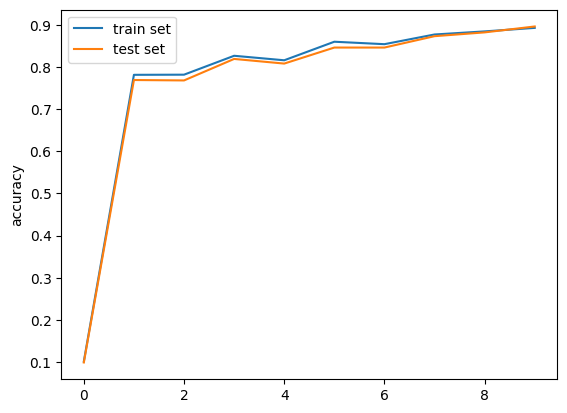

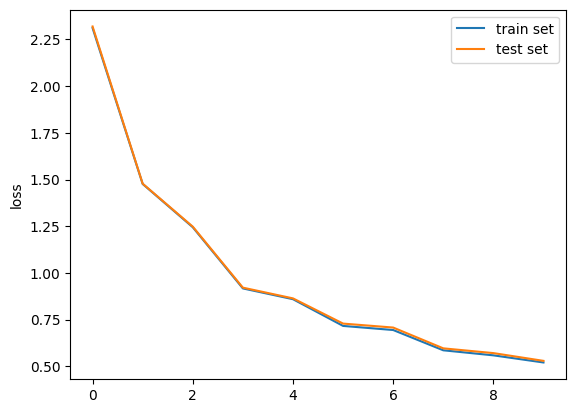

In [10]:
plt.plot(A_Train, label='train set')
plt.plot(A_Test, label='test set')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(L_Train, label='train set')
plt.plot(L_Test, label='test set')
plt.ylabel('loss')
plt.legend()
plt.show()

# CNN

In [ ]:
'''This CNN is LeNet-5'''

class CNN(nn.Module):                                                 # Define model
    def __init__(self):
        super().__init__()
        
        self.layers_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),  # stride's default value is 1
            nn.Tanh(),                                                # shape = [batch_size, 6, 24, 24]
            nn.MaxPool2d(kernel_size=2), # stride's default value is kernel_size, shape = [batch_size, 6, 12, 12]
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), # shape = [batch_size, 16, 8, 8]
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),                              # shape = [batch_size, 16, 4, 4]
            nn.Flatten(),
            nn.Linear(16*4*4, 120),                                   # shape = [batch_size, 120]
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.layers_stack(x)
        return x



def training_cnn(dataset, batch_size, lr_, weight_decay_, epochs, train_dataset, test_dataset):
    
    model = CNN().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=weight_decay_)
    profiler_control = True
    
    A_Train, L_Train, A_Test, L_Test = [], [], [], []
    for t in range(epochs): 
        print(f"Epoch {t+1} ---------------------------------- \n")

        if profiler_control:
            print("Profiling this epoch")
            profiler_control = False
            with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
                A_train, L_train, A_test, L_test = one_epoch(model, loss_fn, optimizer, dataset, batch_size, train_dataset, test_dataset)
                A_Train += A_train
                L_Train += L_train 
                A_Test += A_test
                L_Test += L_test
        else:
            #As training progress, computing and appending loss and accuracy of the model on train and test set
            A_train, L_train, A_test, L_test = one_epoch(model, loss_fn, optimizer, dataset, batch_size, train_dataset, test_dataset)
            A_Train += A_train
            L_Train += L_train 
            A_Test += A_test
            L_Test += L_test
        
        #accuracy, loss = performance_estimate(test_dataset, model, loss_fn, 'test ')
    
    model_state_dict = model.state_dict()           # for saving or loading the trained model
    print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
    return A_Train, L_Train, A_Test, L_Test, model_state_dict




batch_size = 64
print(f'batch_size = {batch_size}\n')

#----------------------------------------------------------------------------------

start_time = time.time()

A_Train, L_Train, A_Test, L_Test, model_state_dict = training_cnn(train_dataset_cnn, batch_size=batch_size, 
                                                              lr_=1e-3, weight_decay_=1e-8, epochs=1, 
                                                              train_dataset=train_dataset_cnn, 
                                                              test_dataset=test_dataset_cnn)

end_time = time.time()

cnn_metrics['time'] = end_time - start_time

print(f' ~~~~~ training is done in {cnn_metrics["time"]}"~~~~~\n')

batch_size = 64

Epoch 1 ---------------------------------- 

Profiling this epoch


d:\Image_classification_with_CNN_and_QNN\venv\Lib\site-packages\torch\autograd\profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


train accuracy: 0.099,  train loss: 2.303
test  accuracy: 0.096,  test  loss: 2.303



In [ ]:
mem_usage = memory_usage((training_cnn, (train_dataset_cnn, batch_size, 1e-3, 1e-8, 1, train_dataset_cnn, test_dataset_cnn)))

In [ ]:
plt.plot(A_Train, label='train set')
plt.plot(A_Test, label='test set')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(L_Train, label='train set')
plt.plot(L_Test, label='test set')
plt.ylabel('loss')
plt.legend()
plt.show()